In [82]:
import os, time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler

from scipy.signal import resample

from recognizer import Recogniser, Point

In [37]:
SAMPLE_POINTS = 50
INPUT_PARAMETERS = 2

SCRIPT_DIR = os.path.abspath('') #os.path.dirname(__file__); workaround for jupyter notebook

TRAIN_PATH = os.path.join(SCRIPT_DIR, "dataset/train")
TEST_PATH = os.path.join(SCRIPT_DIR, "dataset/test")

In [103]:
train_data: list[tuple[str, list[tuple]]] = []
test_data: list[tuple[str, list[tuple]]] = []

In [104]:
def get_data(path: str, data_list: list) -> None:
  for root, _, files in os.walk(path):
    if len(files) == 0:
      continue

    for file_name in files:
      if not file_name.endswith(".csv"):
        continue

      class_name = os.path.basename(root)
      file_path = os.path.join(path, class_name, file_name)

      data = pd.read_csv(filepath_or_buffer=file_path, delimiter=",")

      points = data[["x", "y"]]
      points = np.array(points, dtype=float)

      scaler = StandardScaler()
      points = scaler.fit_transform(points)

      points_resampled = resample(points, SAMPLE_POINTS)

      data_list.append((class_name, points_resampled))

In [105]:
get_data(TRAIN_PATH, train_data)
get_data(TEST_PATH, test_data)

In [106]:
print(test_data[0])

('arrow', array([[-2.178185  ,  0.99153124],
       [-2.26776259,  0.59211023],
       [-2.14967226,  0.73088799],
       [-1.98410903,  0.64462215],
       [-1.80649644,  0.69713812],
       [-1.56667251,  0.51236003],
       [-1.43484472,  0.58330645],
       [-1.23745443,  0.49344059],
       [-0.93565804,  0.41587817],
       [-0.52874398,  0.41704268],
       [-0.18174767,  0.43173345],
       [ 0.19102   ,  0.48780311],
       [ 0.46613195,  0.39719951],
       [ 0.76464554,  0.44686147],
       [ 0.94609066,  0.55979266],
       [ 1.11061219,  0.50775328],
       [ 1.18582344,  0.49832166],
       [ 1.20542192,  0.34802311],
       [ 1.07365091,  0.16298419],
       [ 1.00507662,  0.01527042],
       [ 0.84977166, -0.12242082],
       [ 0.72371717, -0.4063493 ],
       [ 0.5345283 , -0.65575508],
       [ 0.44517207, -0.7155519 ],
       [ 0.27524691, -0.82320905],
       [ 0.1360282 , -1.06518026],
       [-0.07467341, -1.16571298],
       [-0.12144915, -1.21596079],
       [-0

In [107]:
def split_data(data: list[tuple[str, list[tuple]]]) -> tuple[np.ndarray, np.ndarray, list[str]]:
  labels = [sample[0] for sample in data]
  print(set(labels))

  encoder = LabelEncoder()
  labels_encoded = encoder.fit_transform(labels)

  print(set(labels_encoded))

  y = to_categorical(labels_encoded)

  print(len(y[0]))

  sequences = [sample[1] for sample in data]
  X = np.array(sequences)

  return X, y, labels

In [108]:
X_train, y_train, labels_train = split_data(train_data)
X_test, y_test, labels_test = split_data(test_data)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'circle', 'question_mark', 'triangle', 'right_sq_bracket', 'delete_mark', 'v', 'star', 'caret', 'x', 'arrow', 'check', 'left_curly_brace', 'left_sq_bracket', 'rectangle', 'right_curly_brace', 'pigtail'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
16
{'circle', 'question_mark', 'triangle', 'right_sq_bracket', 'delete_mark', 'v', 'star', 'caret', 'x', 'arrow', 'check', 'left_curly_brace', 'left_sq_bracket', 'rectangle', 'right_curly_brace', 'pigtail'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
16
(5120, 50, 2) (160, 50, 2) (5120, 16) (160, 16)


# 1) LSTM Approach

In [57]:
class NN:   

  def init(self, options: dict) -> None:
    self.model = Sequential()

    self.model.add(LSTM(options["lstm_neurons"], input_shape=(SAMPLE_POINTS, INPUT_PARAMETERS)))
    self.model.add(Dense(options["fully_connected_neurons"], activation=options["fully_connected_activation_function"]))
    if options["add_dropout"]:
      self.model.add(Dropout(options["dropout_rate"]))
    self.model.add(Dense(len(set(labels_train)), activation='softmax'))

    self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=options["learn_rate"])
    self.stop_early = EarlyStopping(monitor='val_loss', patience=3)

  def train(self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, options: dict) -> None:
    # Train the model
    self.history = self.model.fit(
      X_train,
      y_train,
      epochs=options["epochs"],
      batch_size=options["batch_size"],
      validation_data=(X_test, y_test),
      verbose=1,
      callbacks=[self.reduce_lr, self.stop_early]
    )

  def summarise(self) -> None:
    self.model.summary()

  def plot(self) -> None:
    loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']
    accuracy = self.history.history['accuracy']
    val_accuracy = self.history.history['val_accuracy']

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)

  def predict(self, X_test: np.ndarray, y_test: np.ndarray, labels_train: list[str]) -> int:
    # let the model make predictions for our training data
    t1 = time.time()
    y_predictions = self.model.predict(X_test)
    t2 = time.time()
    

    # to build a confusion matrix, we have to convert it to classifications
    # this can be done by using the argmax() function to set the probability to 1 and the rest to 0
    y_predictions = np.argmax(y_predictions, axis=1)

    y_test_labels = np.argmax(y_test, axis=1)

    # create and plot confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_predictions)

    fig = plt.figure(figsize=(10, 10))

    ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels_train)).plot(ax=plt.gca())

    plt.xticks(rotation=90, ha='center')
    
    return t2-t1

which hyperparameters make sense to be reduced:
- number of lstm units (default: 64)
- dropout rate (default: not included) -> add to reduce learning rate
- fully connected neurons (default: 32)
- sequence length (default: 100%)
- batch size (default: 32)
- epochs (default: 10)

## iteration 1

Epoch 1/10
160/160 [==============================] - 5s 17ms/step - loss: 1.2430 - accuracy: 0.6543 - val_loss: 0.2940 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 2/10
160/160 [==============================] - 2s 12ms/step - loss: 0.1903 - accuracy: 0.9502 - val_loss: 0.1367 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 3/10
160/160 [==============================] - 2s 13ms/step - loss: 0.0986 - accuracy: 0.9725 - val_loss: 0.1295 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 4/10
160/160 [==============================] - 2s 13ms/step - loss: 0.0696 - accuracy: 0.9793 - val_loss: 0.0852 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/10
160/160 [==============================] - 2s 13ms/step - loss: 0.0513 - accuracy: 0.9857 - val_loss: 0.0440 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 6/10
160/160 [==============================] - 2s 15ms/step - loss: 0.0479 - accuracy: 0.9857 - val_loss: 0.0120 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
160/160 [==============================] - 2s 13ms/st

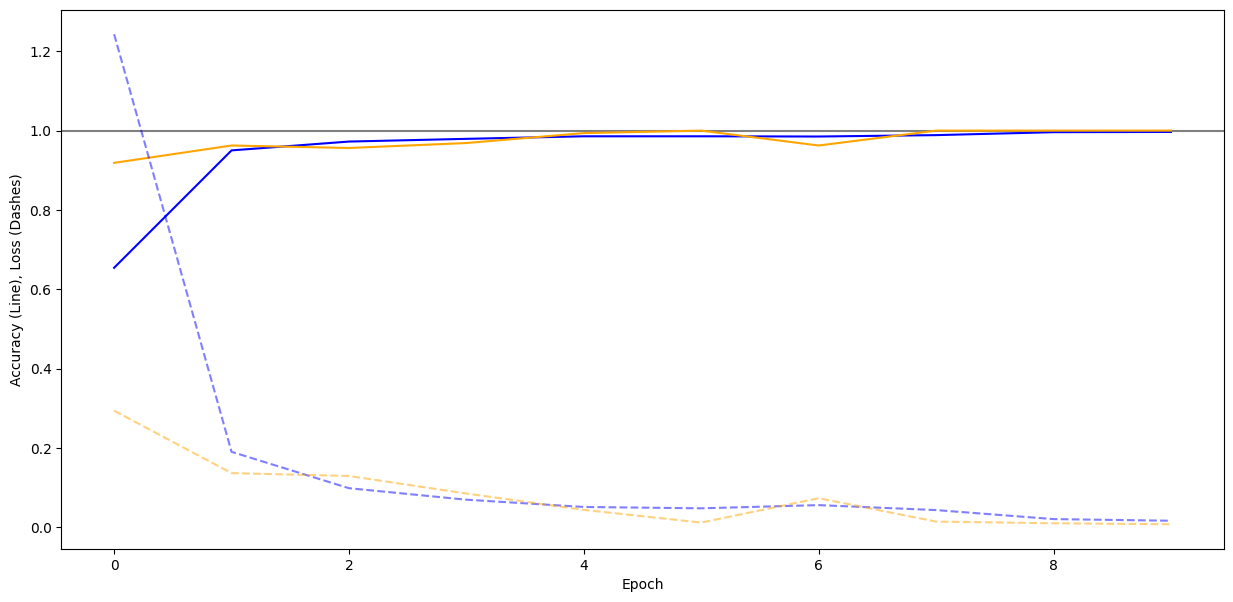

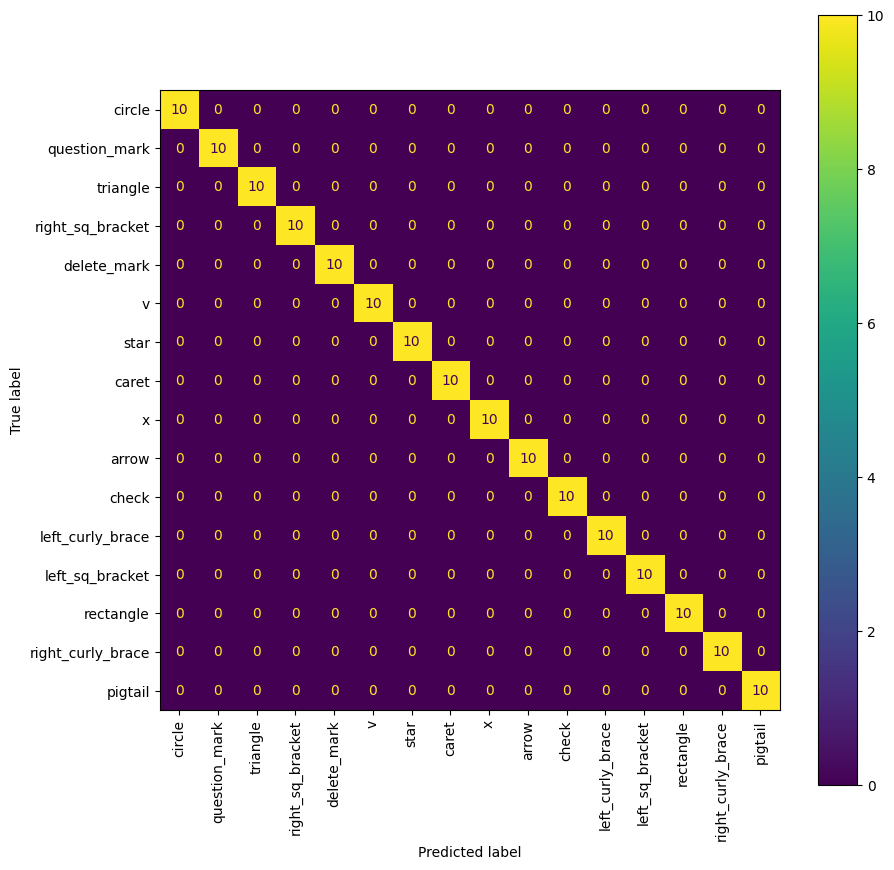

In [68]:
options = {
  "lstm_neurons": 64,
  "fully_connected_neurons": 32,
  "fully_connected_activation_function": "relu",
  "epochs": 10,
  "batch_size": 32,
  "learn_rate": 0.0001,
  "add_dropout": False,
  "dropout_rate": 0.2
}

nn1 = NN()
nn1.init(options)
nn1.train(X_train, y_train, X_test, y_test, options)
nn1.summarise()
nn1.plot()
iteration_1_time = nn1.predict(X_test, y_test, labels_train)

## iteration 2

first, lets reduce the number of neurons from lstm and fully conncected. this should greatly reduce the number of parameters.

Epoch 1/10
160/160 [==============================] - 4s 12ms/step - loss: 2.0131 - accuracy: 0.3805 - val_loss: 0.9900 - val_accuracy: 0.8313 - lr: 0.0010
Epoch 2/10
160/160 [==============================] - 1s 8ms/step - loss: 0.5819 - accuracy: 0.8676 - val_loss: 0.3124 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 3/10
160/160 [==============================] - 1s 8ms/step - loss: 0.2372 - accuracy: 0.9570 - val_loss: 0.1622 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 4/10
160/160 [==============================] - 1s 9ms/step - loss: 0.1280 - accuracy: 0.9715 - val_loss: 0.0793 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 5/10
160/160 [==============================] - 1s 9ms/step - loss: 0.0821 - accuracy: 0.9830 - val_loss: 0.0512 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 6/10
160/160 [==============================] - 1s 9ms/step - loss: 0.0610 - accuracy: 0.9861 - val_loss: 0.0558 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 7/10
160/160 [==============================] - 1s 9ms/step - l

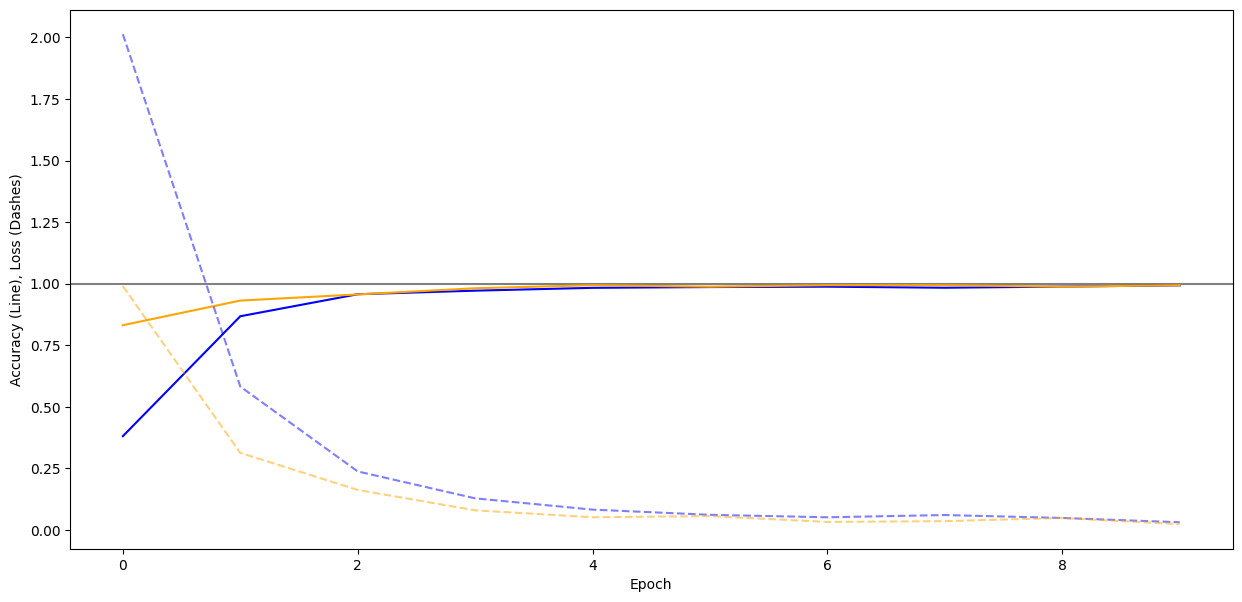

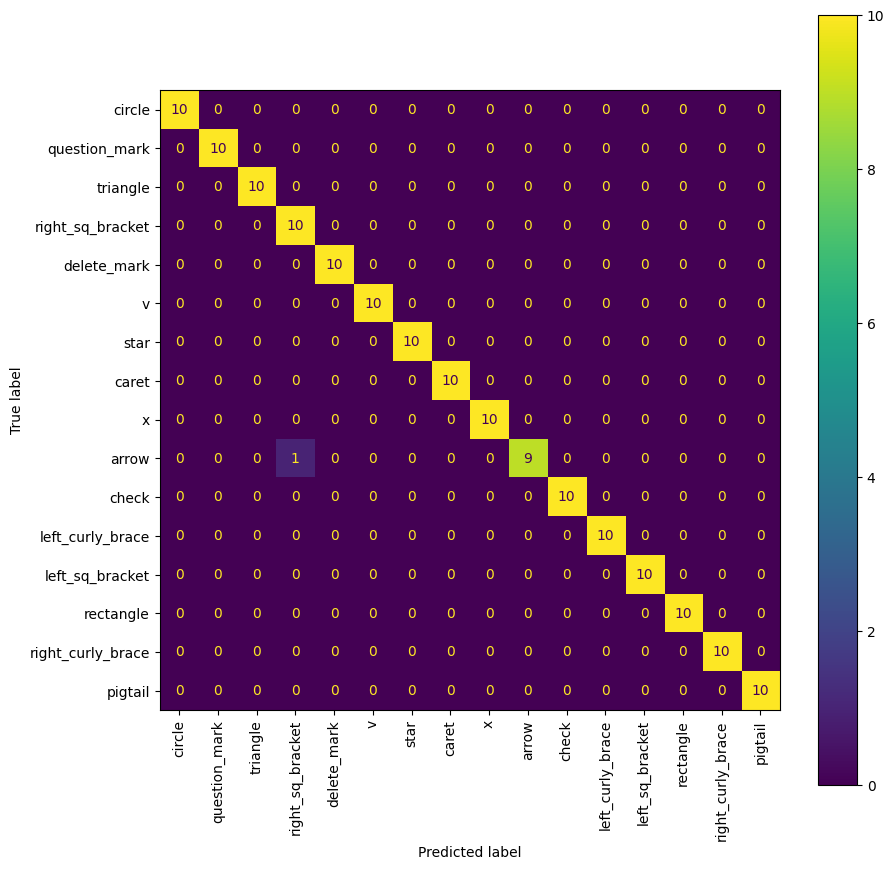

In [69]:
options = {
  "lstm_neurons": 32,
  "fully_connected_neurons": 16,
  "fully_connected_activation_function": "relu",
  "epochs": 10,
  "batch_size": 32,
  "learn_rate": 0.0001,
  "add_dropout": False,
  "dropout_rate": 0.2
}

nn2 = NN()
nn2.init(options)
nn2.train(X_train, y_train, X_test, y_test, options)
nn2.summarise()
nn2.plot()
iteration_2_time = nn2.predict(X_test, y_test, labels_train)

## iteration 3

trying to reduce the number of neurons again

Epoch 1/10
160/160 [==============================] - 3s 10ms/step - loss: 2.4765 - accuracy: 0.2609 - val_loss: 2.0216 - val_accuracy: 0.4187 - lr: 0.0010
Epoch 2/10
160/160 [==============================] - 1s 7ms/step - loss: 1.5842 - accuracy: 0.5645 - val_loss: 1.1791 - val_accuracy: 0.7063 - lr: 0.0010
Epoch 3/10
160/160 [==============================] - 1s 7ms/step - loss: 0.9140 - accuracy: 0.7576 - val_loss: 0.6938 - val_accuracy: 0.8313 - lr: 0.0010
Epoch 4/10
160/160 [==============================] - 1s 7ms/step - loss: 0.5555 - accuracy: 0.8619 - val_loss: 0.4227 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 5/10
160/160 [==============================] - 2s 10ms/step - loss: 0.3516 - accuracy: 0.9066 - val_loss: 0.2578 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 6/10
160/160 [==============================] - 1s 7ms/step - loss: 0.2516 - accuracy: 0.9465 - val_loss: 0.1845 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 7/10
160/160 [==============================] - 1s 8ms/step - 

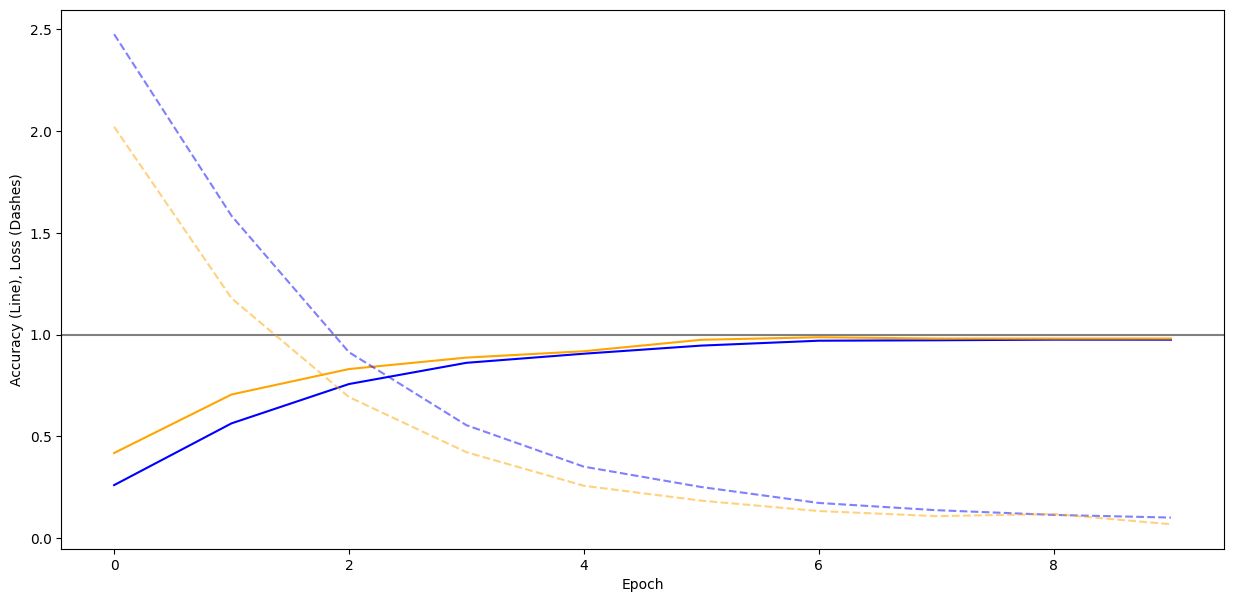

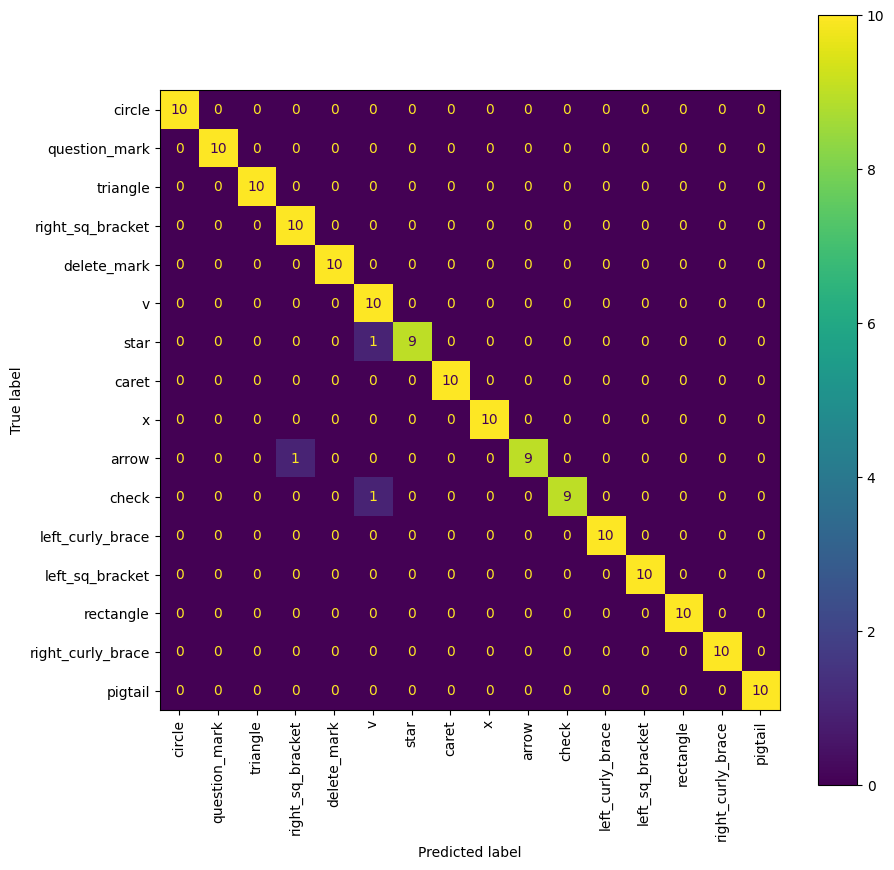

In [71]:
options = {
  "lstm_neurons": 16,
  "fully_connected_neurons": 8,
  "fully_connected_activation_function": "relu",
  "epochs": 10,
  "batch_size": 32,
  "learn_rate": 0.0001,
  "add_dropout": False,
  "dropout_rate": 0.2
}

nn3 = NN()
nn3.init(options)
nn3.train(X_train, y_train, X_test, y_test, options)
nn3.summarise()
nn3.plot()
iteration_3_time = nn3.predict(X_test, y_test, labels_train)

## iteration 4

reducing the lstm units to 16 was a bit too much. the accary droped quite some bit.
we again pick the number of neurons from iteration 3 and now change the epoch size/batch size.

Epoch 1/5
320/320 [==============================] - 4s 9ms/step - loss: 1.4172 - accuracy: 0.6004 - val_loss: 0.4306 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 2/5
320/320 [==============================] - 3s 8ms/step - loss: 0.2464 - accuracy: 0.9510 - val_loss: 0.0861 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 3/5
320/320 [==============================] - 3s 9ms/step - loss: 0.1100 - accuracy: 0.9779 - val_loss: 0.0679 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 4/5
320/320 [==============================] - 3s 8ms/step - loss: 0.0793 - accuracy: 0.9812 - val_loss: 0.0587 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 5/5
320/320 [==============================] - 2s 8ms/step - loss: 0.0702 - accuracy: 0.9836 - val_loss: 0.0460 - val_accuracy: 0.9875 - lr: 0.0010
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 32)                4480      
         

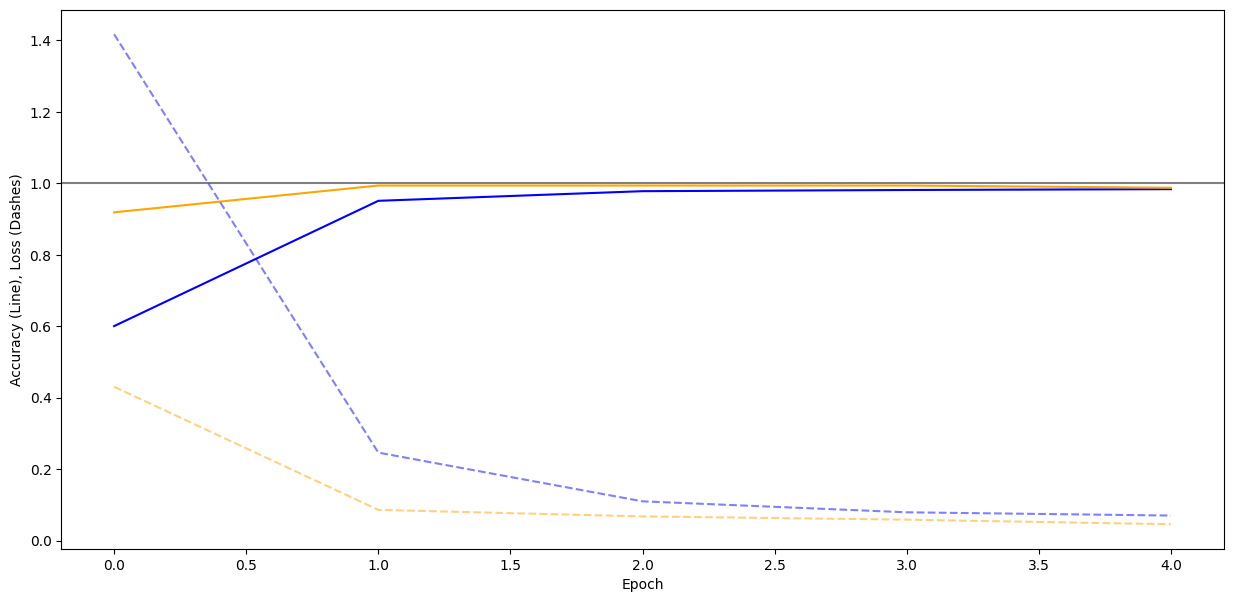

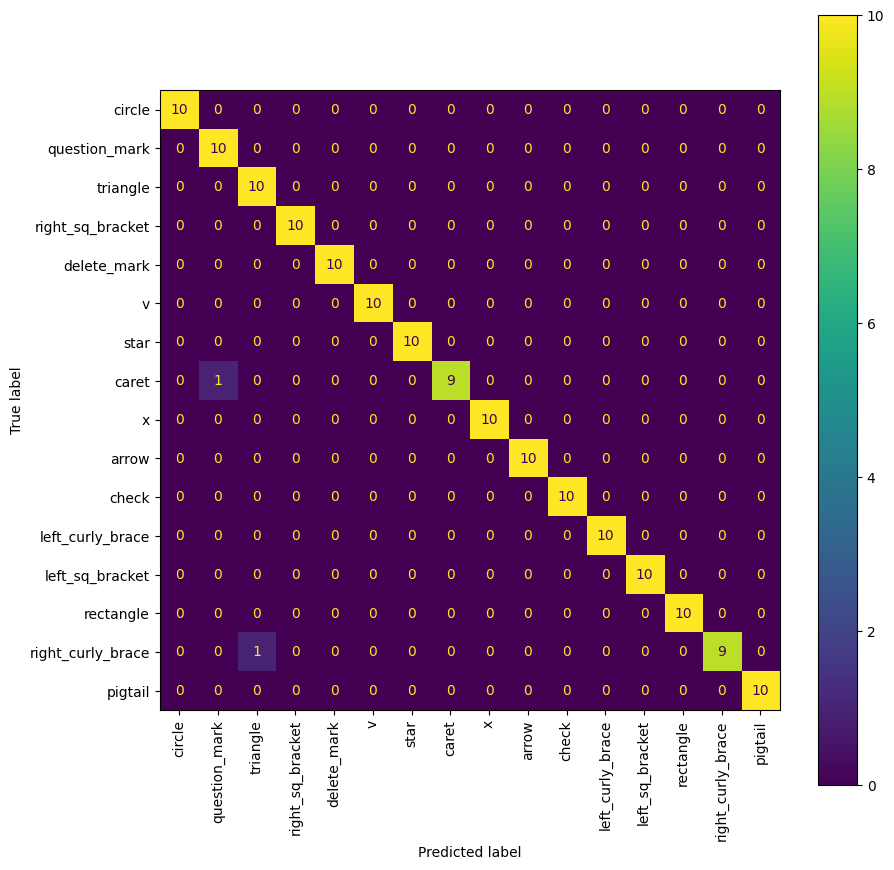

In [73]:
options = {
  "lstm_neurons": 32,
  "fully_connected_neurons": 16,
  "fully_connected_activation_function": "relu",
  "epochs": 5,
  "batch_size": 16,
  "learn_rate": 0.0001,
  "add_dropout": False,
  "dropout_rate": 0.2
}

nn4 = NN()
nn4.init(options)
nn4.train(X_train, y_train, X_test, y_test, options)
nn4.summarise()
nn4.plot()
iteration_4_time = nn4.predict(X_test, y_test, labels_train)

## iteration 5

picking the parameters from iteration 4 and reducing learn rate along with adding a dropout layer.

Epoch 1/5
320/320 [==============================] - 4s 9ms/step - loss: 2.0478 - accuracy: 0.2967 - val_loss: 1.0385 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 2/5
320/320 [==============================] - 2s 7ms/step - loss: 1.1578 - accuracy: 0.5939 - val_loss: 0.4486 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 3/5
320/320 [==============================] - 3s 8ms/step - loss: 0.8812 - accuracy: 0.6773 - val_loss: 0.2084 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 4/5
320/320 [==============================] - 3s 9ms/step - loss: 0.7060 - accuracy: 0.7467 - val_loss: 0.1453 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 5/5
320/320 [==============================] - 3s 9ms/step - loss: 0.6547 - accuracy: 0.7590 - val_loss: 0.1173 - val_accuracy: 0.9812 - lr: 0.0010
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 32)                4480      
         

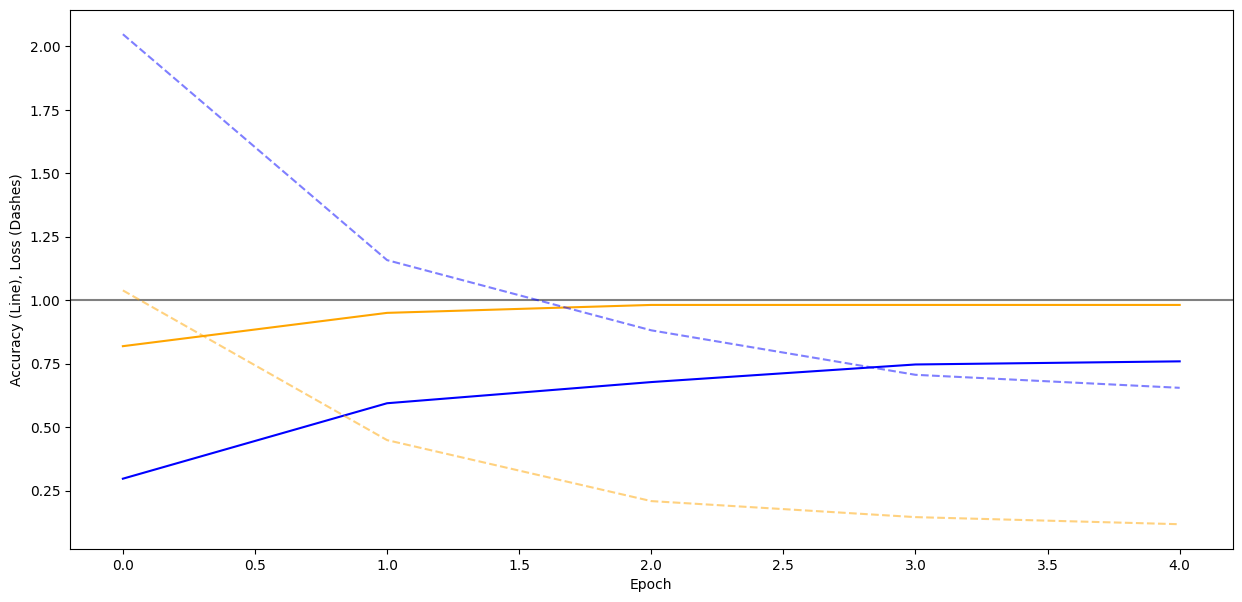

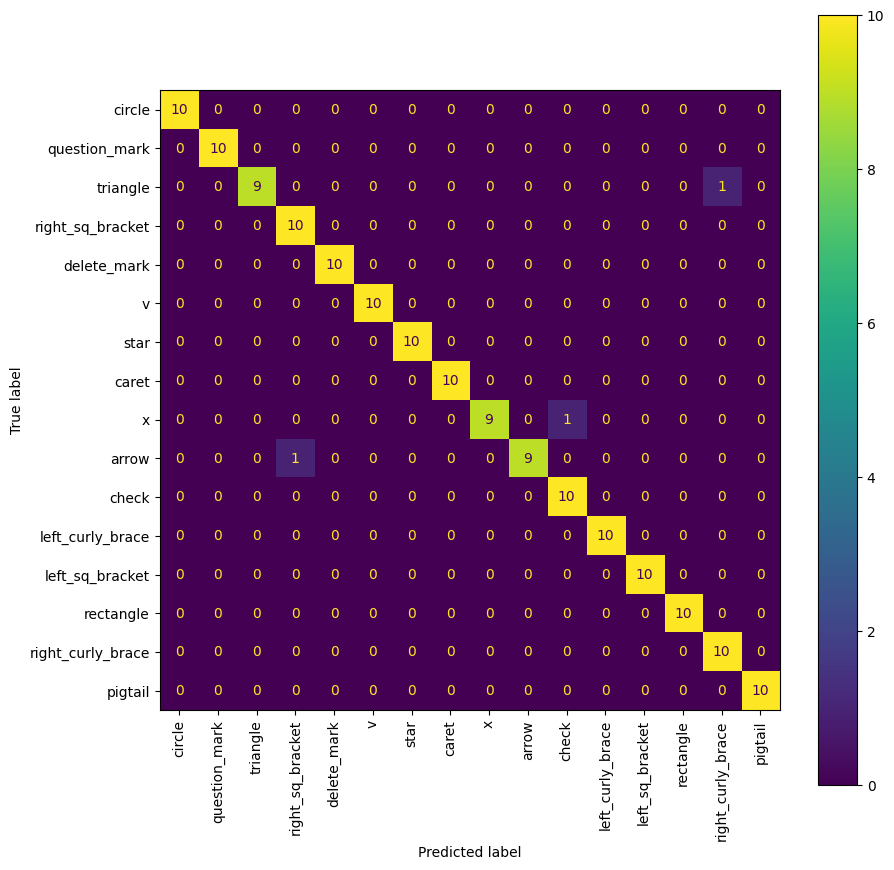

In [76]:
options = {
  "lstm_neurons": 32,
  "fully_connected_neurons": 16,
  "fully_connected_activation_function": "relu",
  "epochs": 5,
  "batch_size": 16,
  "learn_rate": 0.0025,
  "add_dropout": True,
  "dropout_rate": 0.5
}

nn5 = NN()
nn5.init(options)
nn5.train(X_train, y_train, X_test, y_test, options)
nn5.summarise()
nn5.plot()
iteration_5_time = nn5.predict(X_test, y_test, labels_train)

In [118]:
print(iteration_1_time, iteration_2_time, iteration_3_time, iteration_4_time, iteration_5_time)

0.4197201728820801 0.44109320640563965 0.4444890022277832 0.42302489280700684 0.4919400215148926


# 2) 1$ Recogniser Approach

we add the first of each class from the train set and add it as a template to the 1$ recogniser.

In [88]:
rec1 = Recogniser(use_predefined_templates=False)

for data_point in train_data:
  if not data_point[0] in rec1.template_names:
    points = []
    for p in data_point[1]:
      points.append(Point(p[0], p[1]))

    rec1.add_template(data_point[0], points)

print(rec1.template_names)

['arrow', 'triangle', 'rectangle', 'star', 'right_sq_bracket', 'delete_mark', 'caret', 'right_curly_brace', 'circle', 'pigtail', 'check', 'v', 'x', 'left_sq_bracket', 'left_curly_brace', 'question_mark']


In [111]:
def prepare_points(data):
  data_points = []
  
  for p in data:
    class_name = p[0]
    class_points = []

    for i in p[1]:
      class_points.append(Point(i[0], i[1]))

    data_points.append((class_name, class_points))
  
  return data_points


In [115]:
points = prepare_points(test_data)
results = []

for p in points:
  t1 = time.time()
  res = rec1.recognise(p[1])
  t2 = time.time()

  results.append({
    "predicted_class": res[0].name,
    "actual_class": p[0],
    "inference_time": t2-t1,
    "accuracy": res[1],
  })

In [121]:
dollar_accuracy = 0
dollar_inference_time = 0

for r in results:
  if r["predicted_class"] == r["actual_class"]:
    dollar_accuracy += 1
  
  dollar_inference_time += r["inference_time"]

dollar_accuracy = dollar_accuracy / len(results)
dollar_inference_time = dollar_inference_time

In [122]:
print(dollar_accuracy, dollar_inference_time)

0.775 3.360494375228882


# Report

| Approach | Inference Time (s) | Accuracy (%) | LSTM Neurons | FC Neurons | Epochs | Batch Size | Learn Rate | Dropout |
|--------------|-----------|------------|--------------|-----------|------------|--------------|-----------|------------|
| Iteration 1 (LSTM-NN) | 0.42 | 0.997 | 64 | 32 | 10 | 32 | 0.0001 | False |
| Iteration 2 (LSTM-NN) | 0.44 | 0.993 | 32 | 16 | 10 | 32 | 0.0001 | False |
| Iteration 3 (LSTM-NN) | 0.44 | 0.976 | 16 | 8 | 10 | 32 | 0.0001 | False |
| Iteration 4 (LSTM-NN) | 0.42 | 0.984 | 32 | 16 | 5 | 16 | 0.0001 | False |
| Iteration 5 (LSTM-NN) | 0.49 | 0.759 | 32 | 16 | 5 | 16 | 0.0025 | 0.5 |
| $1 Recogniser  (1 template of each class) | 3.36 | 0.775 | -- | -- | -- | -- | -- | -- |


### findings:

- adding more templates to 1$ recogniser might increase accuracy although it would also further increase inference time which is already pretty high.
- 1$ templates have a big limitation e.g. recognition of a circle works good if it was drawn clockwise, but not at all if it was drawn counter-clockwise. this indicates that at least 2 templates for each class are required!
- inference time for lstm-nn is roughly the same for all iterations and we could greatly reduce the number of parameters from 19,760 to 5,280.
- adding a dropout layer and changing min learn rate let accuracy drop to a unusable level (0.76) (requires more iterations and fine-tuning).
- neural network requires more computing power (ram, gpu/cpu) for training and keeping the model in memory whereas $1 recogniser almost requires no memory.


### conclusion:
it shows that one template per class for the 1$ recogniser is insufficient and results in a bad accuracy. it also requires a longer time to predict a gesture compared with multiple iterations of lstm-nn. considering that todays computers have dedicated hardware for neural networks (smartphones and macs have dedicated cpus), i see no point why anyone would not choose a lstm-nn - they predict faster, can be optimised reducing hardware requirements, models can be saved and loaded, and accuracy is almost 100\%. the only advantage of 1$ recogniser is that it is light because it only requires the math package from the standard library whereas lstm-nn requires a few dozen packages. Therefore I choose Iteration 1 because it has almost 100% accuracy and requires the least amount of inference time.